In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from autogluon.tabular import TabularPredictor, TabularDataset
customers = pd.read_csv('customers_labeled.csv')


In [14]:
label = "high_revenue"

In [23]:
X = customers.drop([label], axis=1)
y = customers[label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [12]:
td_train = TabularDataset(train)        

In [13]:
predictor = TabularPredictor(label=label,eval_metric="accuracy").fit(
    train_data=td_train,
    time_limit=60,
    presets="best_quality",
    hyperparameters={
        "GBM": {"extra_trees": True, "ag_args": {"name_suffix":"GBM"}},
        "CAT": {"ag_args": {"name_suffix":"CAT"}},
        "XGB": {"ag_args": {"name_suffix":"XGB"}},
        "RF": {"ag_args": {"name_suffix":"RF"}},
        "NN_TORCH": {"ag_args": {"name_suffix":"NN_TORCH"}},
    }
)


No path specified. Models will be saved in: "AutogluonModels\ag-20250513_130908"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          20
Memory Avail:       4.59 GB / 15.69 GB (29.2%)
Disk Space Avail:   144.89 GB / 471.56 GB (30.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdou

In [25]:
td_test = TabularDataset(test)

In [26]:
y_pred = predictor.predict(td_test.drop(columns=[label]), as_pandas=True)
y_pred

9113     False
3913     False
1008     False
6284     False
5001     False
         ...  
9539     False
10631    False
7730     False
7677     False
9868     False
Name: high_revenue, Length: 2158, dtype: bool

In [27]:
y_pred_proba = predictor.predict_proba(td_test, as_pandas=True)
y_pred_proba

,False,True
9113,0.600691,0.399309
3913,0.990197,0.009803
1008,0.972831,0.027169
6284,0.675943,0.324057
5001,0.995656,0.004344
...,...,...
9539,0.935387,0.064613
10631,0.900056,0.099944
7730,0.656206,0.343794
7677,0.996288,0.003712


In [28]:
predictor.leaderboard(td_test, silent=True)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestRF_BAG_L1,1.000000,0.901734,accuracy,0.155847,0.391830,1.003431,0.155847,0.391830,1.003431,1,True,2
1,RandomForestRF_BAG_L2,0.924930,0.910355,accuracy,0.423909,0.827878,19.905799,0.151162,0.285532,0.966593,2,True,6
2,WeightedEnsemble_L3,0.922150,0.911097,accuracy,0.423909,0.827878,19.986695,0.000000,0.000000,0.080896,3,True,8
3,WeightedEnsemble_L2,0.910565,0.910355,accuracy,0.046900,0.078096,16.590775,0.000000,0.000000,0.046893,2,True,4
4,CatBoostCAT_BAG_L1,0.910565,0.910355,accuracy,0.046900,0.078096,16.543882,0.046900,0.078096,16.543882,1,True,3
5,CatBoostCAT_BAG_L2,0.910102,0.909428,accuracy,0.304211,0.580568,23.600043,0.031465,0.038222,4.660837,2,True,7
6,LightGBMGBM_BAG_L1,0.907785,0.909335,accuracy,0.070000,0.072420,1.391894,0.070000,0.072420,1.391894,1,True,1
7,LightGBMGBM_BAG_L2,0.907785,0.909799,accuracy,0.342103,0.641617,22.367765,0.069356,0.099271,3.428559,2,True,5


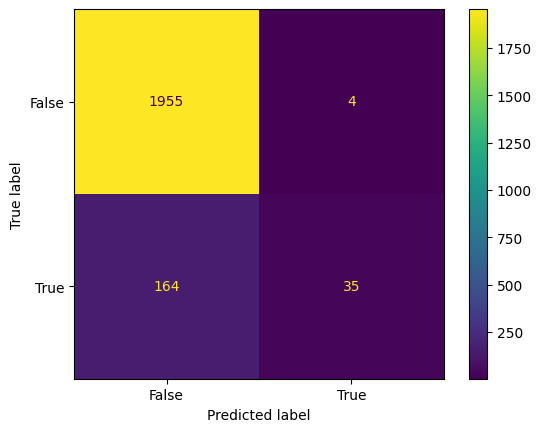

In [31]:
cm = confusion_matrix(td_test[label], y_pred)
ConfusionMatrixDisplay(cm, display_labels=predictor.classes_).plot()